In [4]:
import os
import glob
import json
import logging
from dataclasses import dataclass
import dask.bag
from dask.distributed import Client
#from kerchunk.netCDF3 import NetCDF3ToZarr
#from kerchunk.combine import MultiZarrToZarr
import cftime
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [2]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)


def wmean(arr, w, *args, **kwargs):
    """Wrapper for DataArray.weighted.mean to restore coordinate attributes"""
    wmean = arr.weighted(w).mean(*args, **kwargs)
    return wmean.assign_coords({k:arr[k] for k in wmean.coords})


def T0_T1_T2(ds, coarsen=True):
    """Calculate T0, T1, T2 and return as dict"""
    sinlat = np.sin(np.deg2rad(ds.lat))
    dims = ('lat','lon')
    T0data = wmean(ds.TREFHT, ds.gw, dims).persist()
    T1data = wmean(ds.TREFHT*sinlat, ds.gw, dims).persist()
    T2data = wmean(ds.TREFHT*(3*sinlat**2-1), ds.gw, dims).persist()
    return {'T0':T0data, 'T1':T1data, 'T2':T2data}

In [3]:
client = Client(silence_logs=logging.ERROR)

In [32]:
# Read in low resolution (1 deg) WACCM data
lresWACCM = {
    'control': open_mfdataset('/home/jasperdj/nwo2021025/jasper/GLENS1/TREFHT/EM/'
                               + 'b.e15.B5505C5WCCML45BGCR.f09_g16.control.EM1-3.cam.h0.TREFHT.201001-209807.nc', chunks={'time':1}),
    'sai2020': open_mfdataset('/home/jasperdj/nwo2021025/jasper/GLENS1/TREFHT/EM/'
                              +'b.e15.B5505C5WCCML45BGCR.f09_g16.feedback.EM1-3.cam.h0.TREFHT.202001-209912.nc', chunks={'time':1}),
}

# preprocess control data
lresWACCM['control'] = lresWACCM['control'].isel(time=slice(0,-7))

In [4]:
# Read in low resolution (1 deg) CAM data
lresCAM = {
    'spinup': open_mfdataset('/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/'
                              +'output/cam/hist/*.h0.*.nc', chunks={'time':1}),
    'sai2020': open_mfdataset('/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001/'
                              +'atm/hist/*.h0.*.nc', chunks={'time':1}),
    'sai2050': open_mfdataset('/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001/'
                              +'atm/hist/*.h0.*.nc', chunks={'time':1}),
}

# preprocess spinup data
newtime = [cftime.DatetimeNoLeap(t.year+1800, t.month, t.day) for t in lresCAM['spinup'].time.data]
lresCAM['spinup'] = lresCAM['spinup'].assign_coords({'time':('time',newtime,lresCAM['spinup'].time.attrs)})

Reading combined kerchunk reference file /home/jasperdj/kerchunk/spinup_pd_maxcores_f09_g16.cam2.h0.0001-01_0300-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001.cam2.h0.2000-01_2076-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001.cam2.h0.2000-01_2098-12.json


In [34]:
# Read in medium resolution (0.5 deg) CAM data
mresCAM = {
    'spinup': open_mfdataset('/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/'
                             + 'output/atm/hist/*.h0.*.nc', chunks={'time':1}),
    'control': open_mfdataset('/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12/'
                              + 'atm/hist/yearly/*.h0.avg????.nc', chunks={'time':1}),
    'sai2020': open_mfdataset('/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/'
                              + 'atm/hist/*.h0.*.nc', chunks={'time':1})
}

# preprocess spinup data
newtime = [cftime.DatetimeNoLeap(t.year+1800, t.month, t.day) for t in mresCAM['spinup'].time.data]
mresCAM['spinup'] = mresCAM['spinup'].assign_coords({'time':('time',newtime,mresCAM['spinup'].time.attrs)})

Reading combined kerchunk reference file /home/jasperdj/kerchunk/spinup_pd_maxcores_f05_t12.cam2.h0.0180-01_0300-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/rcp8.5_co2_f05_t12.cam2.h0.avg2000_avg2100.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/mres_b.e10.B2000_CAM5.f05_t12.001.cam2.h0.2045-01_2098-12.json


In [35]:
%%time
# Calculate annual mean T0, T1 and T2

# low resolution WACCM
T_lresWACCM = {}
for exp in lresWACCM:
    T_lresWACCM[exp] = T0_T1_T2(lresWACCM[exp])
    T_lresWACCM[exp] = {k:v.coarsen(time=12).mean() for k,v in T_lresWACCM[exp].items()}
    
# low resolution CAM
T_lresCAM = {}
for exp in lresCAM:
    T_lresCAM[exp] = T0_T1_T2(lresCAM[exp])
    T_lresCAM[exp] = {k:v.coarsen(time=12).mean() for k,v in T_lresCAM[exp].items()}

# medium resolution CAM
T_mresCAM = {}
for exp in mresCAM:
    T_mresCAM[exp] = T0_T1_T2(mresCAM[exp])
    if exp in ['spinup','sai2020']:
        T_mresCAM[exp] = {k:v.coarsen(time=12).mean() for k,v in T_mresCAM[exp].items()}

CPU times: user 10.9 s, sys: 221 ms, total: 11.1 s
Wall time: 11.1 s


In [ ]:
colors = {'

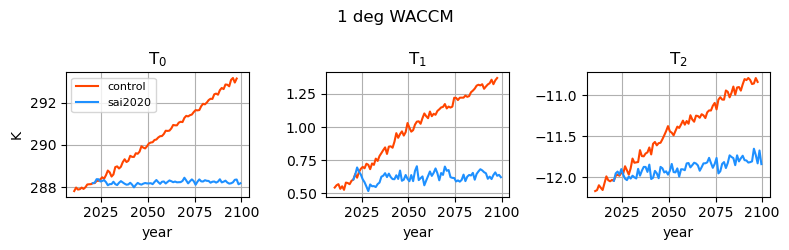

In [48]:
cols = ['orangered','dodgerblue']
labels = ['control','sai2020']
fig, ax = plt.subplots(1,3, figsize=(8,2.5), sharex=True)

for e,exp in enumerate(T_lresWACCM):
    (T_lresWACCM[exp]['T0']).plot(ax=ax[0], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_lresWACCM):
    (T_lresWACCM[exp]['T1']).plot(ax=ax[1], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_lresWACCM):
    (T_lresWACCM[exp]['T2']).plot(ax=ax[2], label=labels[e], c=cols[e])

ax[0].set_title(r'T$_0$')
ax[1].set_title(r'T$_1$')
ax[2].set_title(r'T$_2$')
ax[0].set_ylabel('K')
ax[0].legend(prop={'size':8})
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
fig.suptitle('1 deg WACCM')
plt.tight_layout()

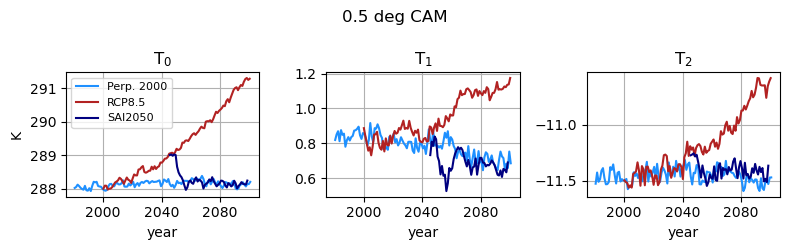

In [49]:
cols = ['dodgerblue','firebrick','navy']
labels = ['Perp. 2000','RCP8.5','SAI2050']
fig, ax = plt.subplots(1,3, figsize=(8,2.5), sharex=True)

for e,exp in enumerate(T_mresCAM):
    (T_mresCAM[exp]['T0']).plot(ax=ax[0], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_mresCAM):
    (T_mresCAM[exp]['T1']).plot(ax=ax[1], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_mresCAM):
    (T_mresCAM[exp]['T2']).plot(ax=ax[2], label=labels[e], c=cols[e])

ax[0].set_title(r'T$_0$')
ax[1].set_title(r'T$_1$')
ax[2].set_title(r'T$_2$')
ax[0].set_ylabel('K')
ax[0].legend(prop={'size':8})
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
fig.suptitle('0.5 deg CAM')
plt.tight_layout()

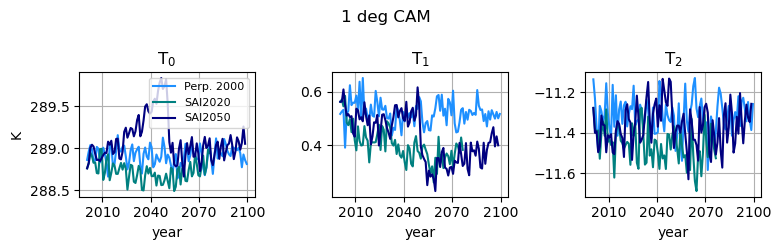

In [51]:
tslice = slice('2000-01-01','2100-01-01')
cols = ['dodgerblue','teal','navy']
labels = ['Perp. 2000','SAI2020','SAI2050']
fig, ax = plt.subplots(1,3, figsize=(8,2.5), sharex=True)

for e,exp in enumerate(T_lresCAM):
    (T_lresCAM[exp]['T0'].sel(time=tslice)).plot(ax=ax[0], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_lresCAM):
    (T_lresCAM[exp]['T1'].sel(time=tslice)).plot(ax=ax[1], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_lresCAM):
    (T_lresCAM[exp]['T2'].sel(time=tslice)).plot(ax=ax[2], label=labels[e], c=cols[e])

ax[0].set_title(r'T$_0$')
ax[1].set_title(r'T$_1$')
ax[2].set_title(r'T$_2$')
ax[0].set_ylabel('K')
ax[0].legend(prop={'size':8})
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
fig.suptitle('1 deg CAM')
plt.tight_layout()

In [ ]:
var = 'TREFHT'
tslice1 = slice('2010','2030')
tslice2 = slice('2075','2095')
da1 = (lresCAM['sai2050'][var].sel(time=tslice2).mean('time')
       -lresCAM['spinup'][var].sel(time=tslice1).mean('time')).compute()
da2 = (mresCAM['sai2050'][var].sel(time=tslice2).mean('time')
       -mresCAM['spinup'][var].sel(time=tslice1).mean('time')).compute()
da3 = (lresWACCM['sai2020'][var].sel(time=tslice2).mean('time')
       -lresWACCM['control'][var].sel(time=tslice1).mean('time').compute()
da4 = {'CAM':da1.mean('lon'), 'HR-CAM':da2.mean('lon'), 'WACCM':da3.mean('lon')}

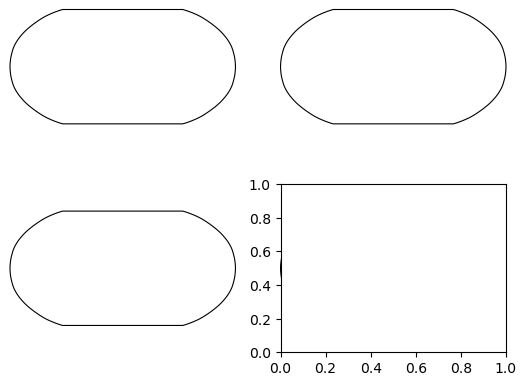

In [8]:
cfkwargs = {'transform':ccrs.PlateCarree(), 'levels':np.linspace(-2,2,9), 'gridlines':True}
cols = ['orangered','firebrick','dodgerblue']
fig, axs = plt.subplots(2,2, subplot_kw={'projection':ccrs.Robinson()})
axs[1,1] = fig.add_subplot(2,2,4)

da1.plot.contourf(ax=axs[0,0], **cfkwargs)
da2.plot.contourf(ax=axs[0,1], **cfkwargs)
da3.plot.contourf(ax=axs[1,0], **cfkwargs)
for i,(k,v) in enumerate(da4.items()):
    v.plot(ax=axs[1,1], label=k, c=cols[i], **lnkwargs)
axs[1,1].legend()